## Assignment 12

In [10]:
# import necessary packages
import keras
import os
from keras import layers
from keras import backend as K
from keras.models import Model
import numpy as np
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.layers import Dense
import matplotlib.pyplot as plt
from scipy.stats import norm

In [3]:
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

In [4]:
# VAE encoder network
img_shape = (28, 28, 1)
batch_size = 16
latent_dim = 2

input_img = keras.Input(shape = img_shape)

x = layers.Conv2D(32, 3, padding = 'same', activation = 'relu')(input_img)
x = layers.Conv2D(64, 3, padding = 'same', activation = 'relu', strides = (2, 2))(x)
x = layers.Conv2D(64, 3, padding = 'same', activation = 'relu')(x)
x = layers.Conv2D(64, 3, padding = 'same', activation = 'relu')(x)

shape_before_flattening = K.int_shape(x)

x = layers.Flatten()(x)
x = layers.Dense(32, activation = 'relu')(x)

z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)

In [5]:
# latent-space-sampling function
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape = (K.shape(z_mean)[0], latent_dim), mean = 0., stddev = 1.)
    
    return z_mean + K.exp(z_log_var) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_var])

In [6]:
# vae decoder network
decoder_input = layers.Input(K.int_shape(z)[1:])

x = layers.Dense(np.prod(shape_before_flattening[1:]), activation = 'relu')(decoder_input)
x = layers.Reshape(shape_before_flattening[1:])(x)
x = layers.Conv2DTranspose(32, 3, padding = 'same', activation = 'relu', strides = (2, 2))(x)
x = layers.Conv2D(1, 3, padding = 'same', activation = 'sigmoid')(x)
                             
decoder = Model(decoder_input, x)
z_decoded = decoder(z)

In [7]:
# custom layer used to computer the VAE loss
class CustomVariationalLayer(keras.layers.Layer):
    
    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        xent_loss = keras.metrics.binary_crossentropy(x, z_decoded)
        kl_loss = -5e-4 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis = 1)
    
        return K.mean(xent_loss + kl_loss)
    
    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs = inputs)
        
        return x

y = CustomVariationalLayer()([input_img, z_decoded])

In [8]:
vae = Model(input_img, y)
vae.compile(optimizer = 'rmsprop', loss = None)
vae.summary()

(x_train, _), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape(x_train.shape + (1,))
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape(x_test.shape + (1,))

# Training the VAE
vae.fit(x = x_train, y = None,
        shuffle = True,
        epochs = 10,
        batch_size = batch_size,
        validation_data = (x_test, None)) 

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 28, 28, 32)   320         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 14, 14, 64)   18496       ['conv2d[0][0]']                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 14, 14, 64)   36928       ['conv2d_1[0][0]']               
                                                                                            

2023-07-25 20:57:13.937775: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-25 20:57:13.965151: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:357] MLIR V1 optimization pass is not enabled
2023-07-25 20:57:14.004604: W tensorflow/c/c_api.cc:291] Operation '{name:'training/RMSprop/conv2d_4/kernel/rms/Assign' id:750 op device:{requested: '', assigned: ''} def:{{{node training/RMSprop/conv2d_4/kernel/rms/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/RMSprop/conv2d_4/kernel/rms, training/RMSprop/conv2d_4/kernel/rms/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will

60000/60000 [==============================] - ETA: 0s - loss: 0.2126

/Users/longtn18/opt/anaconda3/lib/python3.9/site-packages/keras/engine/training_v1.py:2333: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2023-07-25 20:59:15.278237: W tensorflow/c/c_api.cc:291] Operation '{name:'custom_variational_layer/Mean_2' id:360 op device:{requested: '', assigned: ''} def:{{{node custom_variational_layer/Mean_2}} = Mean[T=DT_FLOAT, Tidx=DT_INT32, _has_manual_control_dependencies=true, keep_dims=false](custom_variational_layer/add_4, custom_variational_layer/Const_2)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


60000/60000 [==============================] - 126s 2ms/sample - loss: 0.2126 - val_loss: 0.1976
Epoch 2/10
60000/60000 [==============================] - 123s 2ms/sample - loss: 0.1933 - val_loss: 0.1903
Epoch 3/10
60000/60000 [==============================] - 123s 2ms/sample - loss: 0.1887 - val_loss: 0.1871
Epoch 4/10
60000/60000 [==============================] - 121s 2ms/sample - loss: 0.1862 - val_loss: 0.1838
Epoch 5/10
60000/60000 [==============================] - 125s 2ms/sample - loss: 0.1844 - val_loss: 0.1861
Epoch 6/10
60000/60000 [==============================] - 126s 2ms/sample - loss: 0.1833 - val_loss: 0.1832
Epoch 7/10
60000/60000 [==============================] - 126s 2ms/sample - loss: 0.1823 - val_loss: 0.1822
Epoch 8/10
60000/60000 [==============================] - 121s 2ms/sample - loss: 0.1815 - val_loss: 0.1811
Epoch 9/10
60000/60000 [==============================] - 118s 2ms/sample - loss: 0.1809 - val_loss: 0.1818
Epoch 10/10
60000/60000 [==============

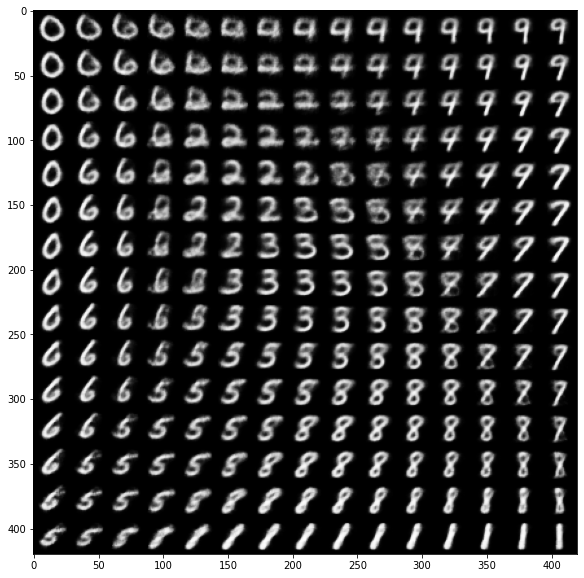

In [12]:
n = 15
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.96, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        x_decoded = decoder.predict(z_sample, batch_size = batch_size)
        
        digit = x_decoded[0].reshape(digit_size, digit_size)
        
        figure[i * digit_size: (i + 1) * digit_size,
              j * digit_size: (j + 1) * digit_size] = digit
        
plt.figure(figsize = (10,10))
plt.imshow(figure, cmap = 'Greys_r')
plt.show()

In [13]:
# generate grid of digits
n = 15
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.96, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        x_decoded = decoder.predict(z_sample, batch_size=batch_size)

        digit = x_decoded[0].reshape(digit_size, digit_size)

        figure[i * digit_size: (i + 1) * digit_size,
              j * digit_size: (j + 1) * digit_size] = digit

In [14]:
# create directory
output_dir = "results/vae"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [15]:
# save the grid
plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.axis('off')
plt.savefig(os.path.join(output_dir, "grid.png"), bbox_inches="tight", pad_inches=0)
plt.close()